# Cross-Attention Pattern Analysis for Sleep Staging

This notebook analyzes attention patterns in multi-modal sleep staging models to identify opportunities for sparse attention optimization.



## Configuration

Set paths and parameters here:

In [7]:
# Model checkpoint path
CHECKPOINT_PATH = '../../outputs/crossattn_ecg_v2_20251104_012157_run1/checkpoints/best_model.pth'

# Data directory containing .h5 files
DATA_DIR = '../../data/mesa_extracted'

# Attention type used in the model 
ATTENTION_TYPE = 'standard'  

# Analysis parameters
NUM_SAMPLES = 20  # Number of samples to analyze
NUM_SAMPLES_SLEEP_STAGE = 30  # Samples for sleep stage analysis
BATCH_SIZE = 1
DEVICE = 'cuda'  # 'cuda' or 'cpu'

# Output directory
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f'outputs/attention_analysis_{TIMESTAMP}'

print("Configuration loaded:")
print(f"  Checkpoint: {CHECKPOINT_PATH}")
print(f"  Data dir: {DATA_DIR}")
print(f"  Attention type: {ATTENTION_TYPE}")
print(f"  Device: {DEVICE}")
print(f"  Output: {OUTPUT_DIR}")

Configuration loaded:
  Checkpoint: ../../outputs/crossattn_ecg_v2_20251104_012157_run1/checkpoints/best_model.pth
  Data dir: ../../data/mesa_extracted
  Attention type: standard
  Device: cuda
  Output: outputs/attention_analysis_20251118_004216


## Setup and Imports

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Enable inline plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
PyTorch version: 2.10.0.dev20251022+cu128
CUDA available: True


In [9]:
# Import model and dataset
from multimodal_model_crossattn import ImprovedMultiModalSleepNet
from multimodal_dataset_aligned import get_dataloaders

print("✓ Model imports successful")

ModuleNotFoundError: No module named 'multimodal_model_crossattn'

## Create Output Directory

In [ ]:
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory created: {output_dir}")

Output directory created: outputs\attention_analysis_20251118_003131


## 4. Load Data

In [ ]:
# Construct data paths
data_dir = Path(DATA_DIR)
data_paths = {
    'ppg': str(data_dir / 'mesa_ppg_with_labels.h5'),
    'real_ecg': str(data_dir / 'mesa_real_ecg.h5'),
    'index': str(data_dir / 'mesa_subject_index.h5')
}

# Validate data files exist
for key, path in data_paths.items():
    if not Path(path).exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    print(f"Found {key}: {path}")

# Load data
_, _, test_loader, _, _, _ = get_dataloaders(
    data_paths, batch_size=BATCH_SIZE, model_type='multimodal'
)
print(f"Data loaded: {len(test_loader)} test samples")

Found ppg: ..\..\data\mesa_extracted\mesa_ppg_with_labels.h5
Found real_ecg: ..\..\data\mesa_extracted\mesa_real_ecg.h5
Found index: ..\..\data\mesa_extracted\mesa_subject_index.h5
Loading data from:
  PPG: ..\..\data\mesa_extracted\mesa_ppg_with_labels.h5
  ECG: ..\..\data\mesa_extracted\mesa_real_ecg.h5
  Index: ..\..\data\mesa_extracted\mesa_subject_index.h5
Using SleepPPG-Net test set split:
  Total valid subjects: 2056
  Test subjects (from SleepPPG-Net): 204
  Train+Val subjects: 1852
train set: 1481 subjects
Loading data from:
  PPG: ..\..\data\mesa_extracted\mesa_ppg_with_labels.h5
  ECG: ..\..\data\mesa_extracted\mesa_real_ecg.h5
  Index: ..\..\data\mesa_extracted\mesa_subject_index.h5
Using SleepPPG-Net test set split:
  Total valid subjects: 2056
  Test subjects (from SleepPPG-Net): 204
  Train+Val subjects: 1852
val set: 371 subjects
Loading data from:
  PPG: ..\..\data\mesa_extracted\mesa_ppg_with_labels.h5
  ECG: ..\..\data\mesa_extracted\mesa_real_ecg.h5
  Index: ..\..\d

## 5. Load Model

In [ ]:
# Validate checkpoint exists
checkpoint_path = Path(CHECKPOINT_PATH)
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

# Check device availability
device = DEVICE
if device == 'cuda' and not torch.cuda.is_available():
    print("CUDA not available, using CPU")
    device = 'cpu'

# Load model
print(f"Loading model with {ATTENTION_TYPE} attention...")
model = ImprovedMultiModalSleepNet(
    n_classes=4, 
    d_model=256, 
    n_heads=8,
    attention_type=ATTENTION_TYPE
)

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded")
print(f"  Parameters: {total_params:,}")
print(f"  Device: {device}")
print(f"  Attention type: {ATTENTION_TYPE}")

Loading model with standard attention...
Model loaded
  Parameters: 14,864,582
  Device: cuda
  Attention type: standard


## Define Analysis Functions

In [ ]:
class AttentionPatternAnalyzer:
    """Analyze cross-attention patterns to identify sparsity opportunities"""
    
    def __init__(self, model, device='cuda', attention_type='standard'):
        self.model = model.to(device)
        self.device = device
        self.attention_type = attention_type
        self.model.eval()
        
        # Validate attention type
        if attention_type not in ['standard', 'sparse']:
            raise ValueError(
                f"AttentionPatternAnalyzer only supports 'standard' or 'sparse' attention.\n"
                f"Linear attention returns None for attention weights and cannot be analyzed.\n"
                f"Got: {attention_type}"
            )
        
    def register_attention_hooks(self):
        """Register hooks to capture attention weights from all cross-attention layers"""
        hooks = []
        attention_weights = {}
        
        def make_hook(name):
            def hook(module, input, output):
                # output is (attended_features, attention_weights)
                if isinstance(output, tuple) and len(output) == 2:
                    attn = output[1]
                    if attn is not None:  # Check for None (linear attention)
                        attention_weights[name] = attn.detach().cpu()
                    else:
                        print(f"⚠️  Warning: {name} returned None for attention weights")
            return hook
        
        # Register hooks on cross-attention modules
        for name, module in self.model.named_modules():
            if isinstance(module, type(self.model.fusion_blocks[0].ppg_cross_attn)):
                hook = module.register_forward_hook(make_hook(name))
                hooks.append(hook)
        
        return hooks, attention_weights
    
    def remove_hooks(self, hooks):
        """Remove all registered hooks"""
        for hook in hooks:
            hook.remove()
    
    def analyze_batch(self, ppg, ecg, labels=None):
        """Analyze attention patterns for a single batch"""
        ppg = ppg.to(self.device)
        ecg = ecg.to(self.device)
        
        hooks, attention_weights = self.register_attention_hooks()
        
        with torch.no_grad():
            _ = self.model(ppg, ecg)
        
        self.remove_hooks(hooks)
        
        # Validate that we got attention weights
        if not attention_weights:
            raise RuntimeError(
                "No attention weights were captured! This likely means:\n"
                "1. Model is using linear attention (which returns None), or\n"
                "2. Hook registration failed.\n"
                "Please ensure you're using 'standard' or 'sparse' attention."
            )
        
        return attention_weights, labels
    
    def compute_sparsity_metrics(self, attention_weights):
        """Compute various sparsity metrics for attention patterns"""
        metrics = {}
        
        for layer_name, attn in attention_weights.items():
            # attn shape: [batch, heads, query_len, key_len]
            attn_np = attn.numpy()
            
            # Average across batch and heads
            avg_attn = attn_np.mean(axis=(0, 1))
            
            # Sparsity metrics
            metrics[layer_name] = {
                'shape': list(attn.shape),
                'mean': float(avg_attn.mean()),
                'std': float(avg_attn.std()),
                'max': float(avg_attn.max()),
                'min': float(avg_attn.min()),
                
                # Sparsity: percentage of weights below threshold
                'sparsity_50pct': float((avg_attn < avg_attn.mean()).sum() / avg_attn.size),
                'sparsity_90pct': float((avg_attn < avg_attn.mean() + avg_attn.std()).sum() / avg_attn.size),
                'sparsity_99pct': float((avg_attn < avg_attn.mean() + 2*avg_attn.std()).sum() / avg_attn.size),
                
                # Entropy (measure of focus)
                'entropy': self._compute_entropy(avg_attn),
                
                # Diagonal dominance (temporal alignment)
                'diagonal_ratio': self._compute_diagonal_ratio(avg_attn),
                
                # Local vs global attention
                'local_ratio_64': self._compute_local_ratio(avg_attn, window=64),
                'local_ratio_128': self._compute_local_ratio(avg_attn, window=128),
                'local_ratio_256': self._compute_local_ratio(avg_attn, window=256),
            }
        
        return metrics
    
    def _compute_entropy(self, attn_matrix):
        """Compute average entropy of attention distributions"""
        entropies = []
        for i in range(attn_matrix.shape[0]):
            row = attn_matrix[i]
            row_norm = row / (row.sum() + 1e-9)
            ent = entropy(row_norm + 1e-9)
            entropies.append(ent)
        return float(np.mean(entropies))
    
    def _compute_diagonal_ratio(self, attn_matrix):
        """Compute ratio of attention on diagonal (temporally aligned)"""
        min_dim = min(attn_matrix.shape)
        diagonal = np.diag(attn_matrix[:min_dim, :min_dim])
        return float(diagonal.mean() / attn_matrix.mean())
    
    def _compute_local_ratio(self, attn_matrix, window=64):
        """Compute ratio of attention within local window"""
        h, w = attn_matrix.shape
        mask = np.abs(np.arange(h)[:, None] - np.arange(w)[None, :]) <= window
        local_sum = attn_matrix[mask].sum()
        total_sum = attn_matrix.sum()
        return float(local_sum / (total_sum + 1e-9))

print("✓ Analyzer class defined (with full validation and error handling)")

✓ Analyzer class defined (with full validation and error handling)


In [ ]:
def compute_sparsity_metrics(attn):
    """Compute comprehensive sparsity metrics for attention matrix
    
    This function extracts metrics from a single layer's attention tensor.
    For full multi-layer analysis, use analyzer.compute_sparsity_metrics()
    """
    # Average across batch and heads
    avg_attn = attn.mean(dim=(0, 1)).numpy()
    
    # Compute entropy
    entropies = []
    for i in range(avg_attn.shape[0]):
        row = avg_attn[i]
        row_norm = row / (row.sum() + 1e-9)
        ent = entropy(row_norm + 1e-9)
        entropies.append(ent)
    
    # Diagonal ratio
    min_dim = min(avg_attn.shape)
    diagonal = np.diag(avg_attn[:min_dim, :min_dim])
    diagonal_ratio = diagonal.mean() / (avg_attn.mean() + 1e-9)
    
    # Local ratios
    def compute_local_ratio(window):
        h, w = avg_attn.shape
        mask = np.abs(np.arange(h)[:, None] - np.arange(w)[None, :]) <= window
        return avg_attn[mask].sum() / (avg_attn.sum() + 1e-9)
    
    return {
        'shape': list(attn.shape),
        'mean': float(avg_attn.mean()),
        'std': float(avg_attn.std()),
        'max': float(avg_attn.max()),
        'min': float(avg_attn.min()),
        'entropy': float(np.mean(entropies)),
        'diagonal_ratio': float(diagonal_ratio),
        'local_ratio_64': float(compute_local_ratio(64)),
        'local_ratio_128': float(compute_local_ratio(128)),
        'local_ratio_256': float(compute_local_ratio(256)),
        'sparsity_50pct': float((avg_attn < avg_attn.mean()).sum() / avg_attn.size),
        'sparsity_90pct': float((avg_attn < avg_attn.mean() + avg_attn.std()).sum() / avg_attn.size),
        'sparsity_99pct': float((avg_attn < avg_attn.mean() + 2*avg_attn.std()).sum() / avg_attn.size),
    }

print("✓ Metrics function defined (with full sparsity metrics)")

✓ Metrics function defined (with full sparsity metrics)


## 7. Create Analyzer and Test

In [ ]:
analyzer = AttentionPatternAnalyzer(model, device=device, attention_type=ATTENTION_TYPE)

# Test on first batch
print("Testing analyzer on first batch...")
test_ppg, test_ecg, test_labels = next(iter(test_loader))
test_attention, _ = analyzer.analyze_batch(test_ppg, test_ecg, test_labels)

print(f"\n✓ Captured {len(test_attention)} attention layers:")
for name, attn in test_attention.items():
    print(f"  {name}: {attn.shape}")

Testing analyzer on first batch...

✓ Captured 6 attention layers:
  fusion_blocks.0.ppg_cross_attn: torch.Size([1, 8, 2400, 2400])
  fusion_blocks.0.ecg_cross_attn: torch.Size([1, 8, 2400, 2400])
  fusion_blocks.1.ppg_cross_attn: torch.Size([1, 8, 2400, 2400])
  fusion_blocks.1.ecg_cross_attn: torch.Size([1, 8, 2400, 2400])
  fusion_blocks.2.ppg_cross_attn: torch.Size([1, 8, 2400, 2400])
  fusion_blocks.2.ecg_cross_attn: torch.Size([1, 8, 2400, 2400])


## 8. Visualize First Sample - Full Attention Heatmap

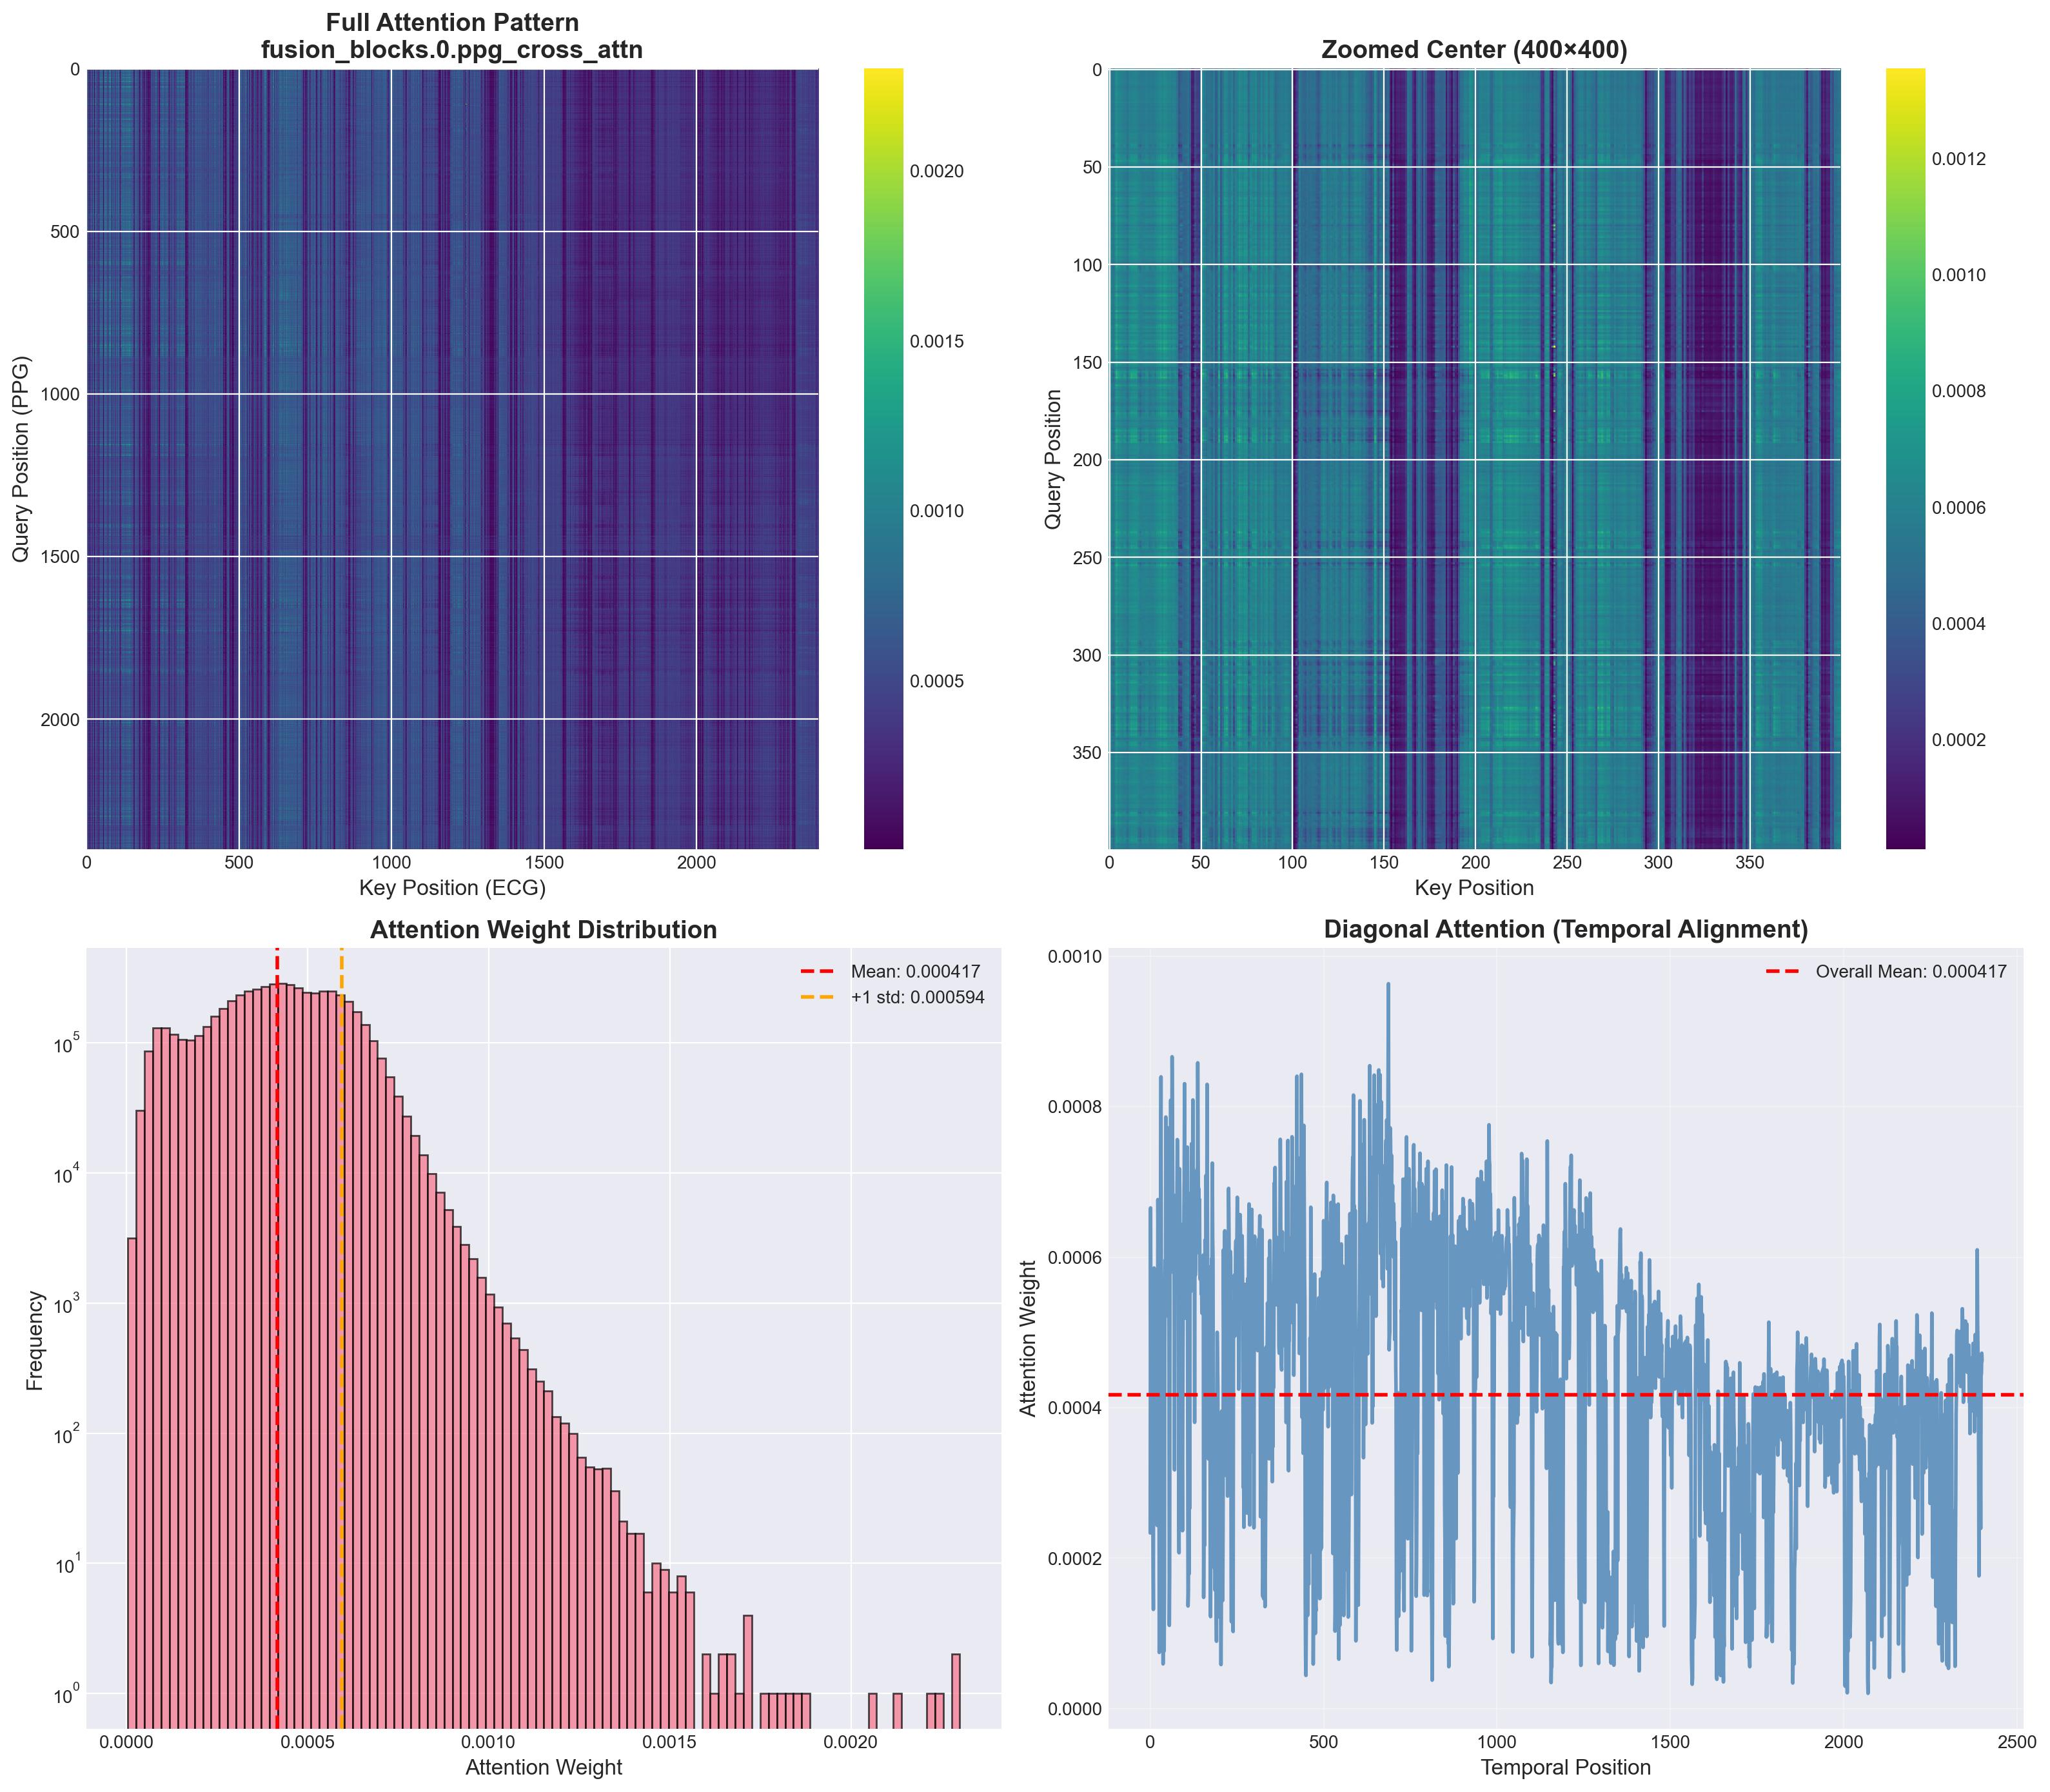

✓ Saved to outputs\attention_analysis_20251118_003131\attention_heatmap_layer0.png


In [ ]:
# Get first layer attention
layer_name = list(test_attention.keys())[0]
attn = test_attention[layer_name]
avg_attn = attn.mean(dim=(0, 1)).numpy()

# Create detailed visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Full attention matrix
im1 = axes[0, 0].imshow(avg_attn, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0, 0].set_title(f'Full Attention Pattern\n{layer_name}', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Key Position (ECG)', fontsize=12)
axes[0, 0].set_ylabel('Query Position (PPG)', fontsize=12)
plt.colorbar(im1, ax=axes[0, 0])

# Zoomed center
h, w = avg_attn.shape
center_h, center_w = h // 2, w // 2
zoom_size = 200
zoomed = avg_attn[
    max(0, center_h-zoom_size):min(h, center_h+zoom_size),
    max(0, center_w-zoom_size):min(w, center_w+zoom_size)
]
im2 = axes[0, 1].imshow(zoomed, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0, 1].set_title('Zoomed Center (400×400)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Key Position', fontsize=12)
axes[0, 1].set_ylabel('Query Position', fontsize=12)
plt.colorbar(im2, ax=axes[0, 1])

# Distribution histogram
axes[1, 0].hist(avg_attn.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(avg_attn.mean(), color='r', linestyle='--', linewidth=2,
                  label=f'Mean: {avg_attn.mean():.6f}')
axes[1, 0].axvline(avg_attn.mean() + avg_attn.std(), color='orange', linestyle='--', linewidth=2,
                  label=f'+1 std: {avg_attn.mean() + avg_attn.std():.6f}')
axes[1, 0].set_xlabel('Attention Weight', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Attention Weight Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].set_yscale('log')

# Diagonal profile
min_dim = min(avg_attn.shape)
diagonal = np.array([avg_attn[i, i] for i in range(min_dim)])
axes[1, 1].plot(diagonal, alpha=0.8, linewidth=2, color='steelblue')
axes[1, 1].axhline(avg_attn.mean(), color='r', linestyle='--', linewidth=2,
                  label=f'Overall Mean: {avg_attn.mean():.6f}')
axes[1, 1].set_xlabel('Temporal Position', fontsize=12)
axes[1, 1].set_ylabel('Attention Weight', fontsize=12)
axes[1, 1].set_title('Diagonal Attention (Temporal Alignment)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'attention_heatmap_layer0.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {output_dir / 'attention_heatmap_layer0.png'}")

## 9. Analyze Local Attention Bands

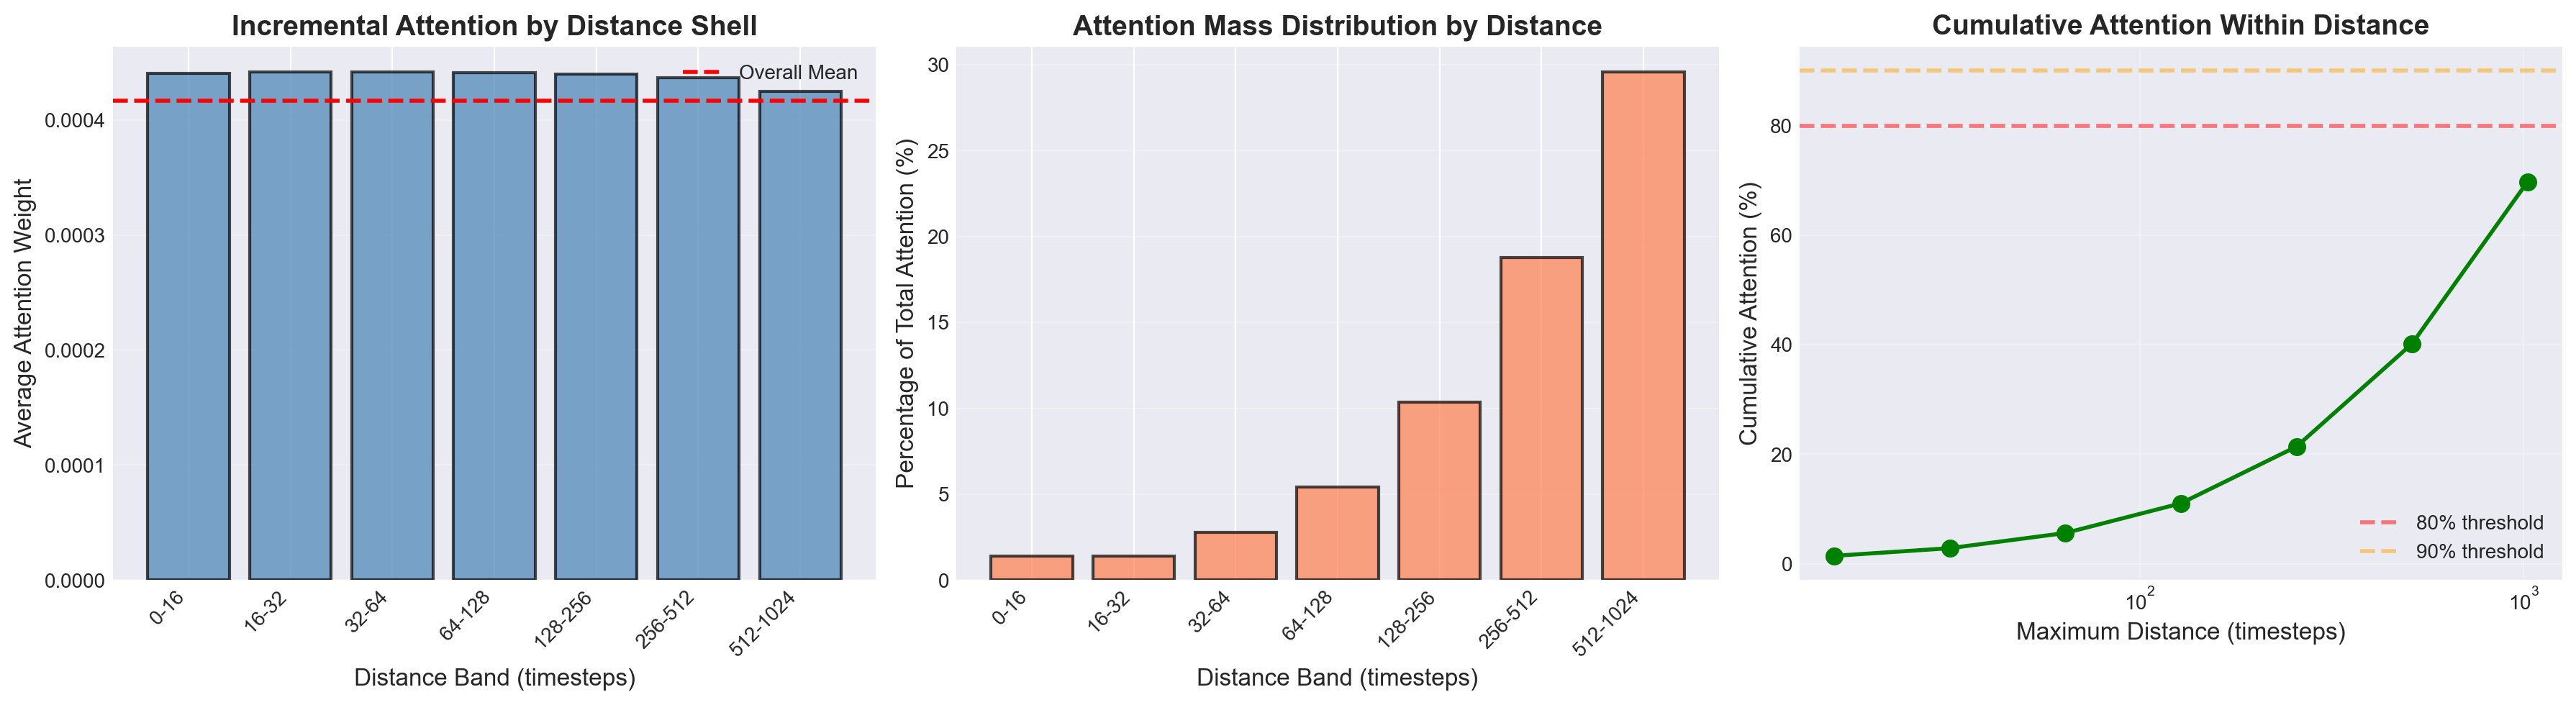


🔍 INCREMENTAL SHELL ANALYSIS (Non-overlapping bands):
  Distance Band | Avg Strength |   Mass % | Cumulative
----------------------------------------------------------------------
           0-16 |     0.000440 |    1.40% |       1.4%
          16-32 |     0.000441 |    1.40% |       2.8%
          32-64 |     0.000442 |    2.77% |       5.6%
         64-128 |     0.000441 |    5.42% |      11.0%
        128-256 |     0.000440 |   10.35% |      21.4%
        256-512 |     0.000437 |   18.79% |      40.2%
       512-1024 |     0.000425 |   29.58% |      69.7%

💡 Key Insights:
  • Overall mean attention: 0.000417
  • Attention within 128 steps: 11.0%
  • Attention within 256 steps: 21.4%


In [ ]:
# Define band edges (including 0 for proper shell computation)
band_edges = [0, 16, 32, 64, 128, 256, 512, 1024]
band_labels = ['0-16', '16-32', '32-64', '64-128', '128-256', '256-512', '512-1024']
incremental_strengths = []
incremental_mass = []  # Percentage of total attention in each shell
cumulative_attn = []

h, w = avg_attn.shape
distance_matrix = np.abs(np.arange(h)[:, None] - np.arange(w)[None, :])

# Compute INCREMENTAL band shells (non-overlapping)
for i in range(len(band_edges) - 1):
    lower = band_edges[i]
    upper = band_edges[i + 1]
    
    # Mask for this shell only (not cumulative)
    shell_mask = (distance_matrix > lower) & (distance_matrix <= upper)
    
    if shell_mask.sum() > 0:
        # Average attention in this shell
        incremental_strengths.append(avg_attn[shell_mask].mean())
        # Percentage of total attention in this shell
        incremental_mass.append(avg_attn[shell_mask].sum() / avg_attn.sum() * 100)
    else:
        incremental_strengths.append(0)
        incremental_mass.append(0)

# Compute CUMULATIVE attention at each band edge
for band_width in band_edges[1:]:
    mask = distance_matrix <= band_width
    cumulative_attn.append(avg_attn[mask].sum() / avg_attn.sum())

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Incremental strength (mean attention in each shell)
ax1.bar(range(len(band_labels)), incremental_strengths, alpha=0.7, 
        edgecolor='black', linewidth=1.5, color='steelblue')
ax1.set_xticks(range(len(band_labels)))
ax1.set_xticklabels(band_labels, rotation=45, ha='right')
ax1.set_xlabel('Distance Band (timesteps)', fontsize=12)
ax1.set_ylabel('Average Attention Weight', fontsize=12)
ax1.set_title('Incremental Attention by Distance Shell', fontsize=14, fontweight='bold')
ax1.axhline(avg_attn.mean(), color='r', linestyle='--', linewidth=2, label='Overall Mean')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Incremental mass (percentage of attention in each shell)
ax2.bar(range(len(band_labels)), incremental_mass, alpha=0.7, 
        edgecolor='black', linewidth=1.5, color='coral')
ax2.set_xticks(range(len(band_labels)))
ax2.set_xticklabels(band_labels, rotation=45, ha='right')
ax2.set_xlabel('Distance Band (timesteps)', fontsize=12)
ax2.set_ylabel('Percentage of Total Attention (%)', fontsize=12)
ax2.set_title('Attention Mass Distribution by Distance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Cumulative attention
ax3.plot(band_edges[1:], [c * 100 for c in cumulative_attn], marker='o', 
        linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Maximum Distance (timesteps)', fontsize=12)
ax3.set_ylabel('Cumulative Attention (%)', fontsize=12)
ax3.set_title('Cumulative Attention Within Distance', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axhline(80, color='r', linestyle='--', alpha=0.5, linewidth=2, label='80% threshold')
ax3.axhline(90, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='90% threshold')
ax3.legend(fontsize=10)
ax3.set_xscale('log')

plt.tight_layout()
plt.savefig(output_dir / 'local_attention_bands.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results
print("\n🔍 INCREMENTAL SHELL ANALYSIS (Non-overlapping bands):")
print("=" * 70)
print(f"{'Distance Band':>15} | {'Avg Strength':>12} | {'Mass %':>8} | {'Cumulative':>10}")
print("-" * 70)
for i, (label, strength, mass, cum) in enumerate(zip(band_labels, incremental_strengths, incremental_mass, cumulative_attn)):
    print(f"{label:>15} | {strength:12.6f} | {mass:7.2f}% | {cum*100:9.1f}%")

print("\n💡 Key Insights:")
print(f"  • Overall mean attention: {avg_attn.mean():.6f}")
print(f"  • Attention within 128 steps: {cumulative_attn[3]*100:.1f}%")
print(f"  • Attention within 256 steps: {cumulative_attn[4]*100:.1f}%")

## 10. Analyze Multiple Samples

In [ ]:
print(f"Analyzing {NUM_SAMPLES} samples...")
all_metrics = []

for i, (ppg, ecg, labels) in enumerate(test_loader):
    if i >= NUM_SAMPLES:
        break
    
    attention_weights, _ = analyzer.analyze_batch(ppg, ecg, labels)
    
    sample_metrics = {}
    for layer_name, attn in attention_weights.items():
        sample_metrics[layer_name] = compute_sparsity_metrics(attn)
    
    all_metrics.append(sample_metrics)
    
    if (i + 1) % 5 == 0:
        print(f"  Processed {i+1}/{NUM_SAMPLES} samples")

print(f"\n✓ Analyzed {len(all_metrics)} samples")

Analyzing 20 samples...
  Processed 5/20 samples
  Processed 10/20 samples
  Processed 15/20 samples
  Processed 20/20 samples

✓ Analyzed 20 samples


## 11. Aggregate Metrics Across Samples

In [ ]:
# Aggregate metrics
aggregate_metrics = {}
layer_names = list(all_metrics[0].keys())

for layer_name in layer_names:
    aggregate_metrics[layer_name] = {}
    for metric_key in all_metrics[0][layer_name].keys():
        values = [m[layer_name][metric_key] for m in all_metrics]
        aggregate_metrics[layer_name][metric_key] = {
            'mean': float(np.mean(values)),
            'std': float(np.std(values)),
            'min': float(np.min(values)),
            'max': float(np.max(values))
        }

# Display summary table
print("\n" + "="*80)
print("AGGREGATE METRICS SUMMARY")
print("="*80)

for layer_name in layer_names:
    print(f"\n{layer_name}:")
    print("-" * 80)
    metrics = aggregate_metrics[layer_name]
    
    print(f"  Entropy:        {metrics['entropy']['mean']:.3f} ± {metrics['entropy']['std']:.3f}")
    print(f"  Mean attn:      {metrics['mean']['mean']:.6f} ± {metrics['mean']['std']:.6f}")
    print(f"  Diagonal ratio: {metrics['diagonal_ratio']['mean']:.3f} ± {metrics['diagonal_ratio']['std']:.3f}")
    print(f"  Local 64:       {metrics['local_ratio_64']['mean']*100:.1f}%")
    print(f"  Local 128:      {metrics['local_ratio_128']['mean']*100:.1f}%")
    print(f"  Local 256:      {metrics['local_ratio_256']['mean']*100:.1f}%")


AGGREGATE METRICS SUMMARY

fusion_blocks.0.ppg_cross_attn:
--------------------------------------------------------------------------------
  Entropy:        7.668 ± 0.032
  Mean attn:      0.000417 ± 0.000000
  Diagonal ratio: 1.062 ± 0.045
  Local 64:       5.7%
  Local 128:      11.3%
  Local 256:      21.9%

fusion_blocks.0.ecg_cross_attn:
--------------------------------------------------------------------------------
  Entropy:        7.686 ± 0.034
  Mean attn:      0.000417 ± 0.000000
  Diagonal ratio: 1.025 ± 0.040
  Local 64:       5.4%
  Local 128:      10.7%
  Local 256:      20.8%

fusion_blocks.1.ppg_cross_attn:
--------------------------------------------------------------------------------
  Entropy:        7.740 ± 0.013
  Mean attn:      0.000417 ± 0.000000
  Diagonal ratio: 1.012 ± 0.028
  Local 64:       5.4%
  Local 128:      10.6%
  Local 256:      20.6%

fusion_blocks.1.ecg_cross_attn:
-------------------------------------------------------------------------------

## 12. Visualize Metrics Across Layers

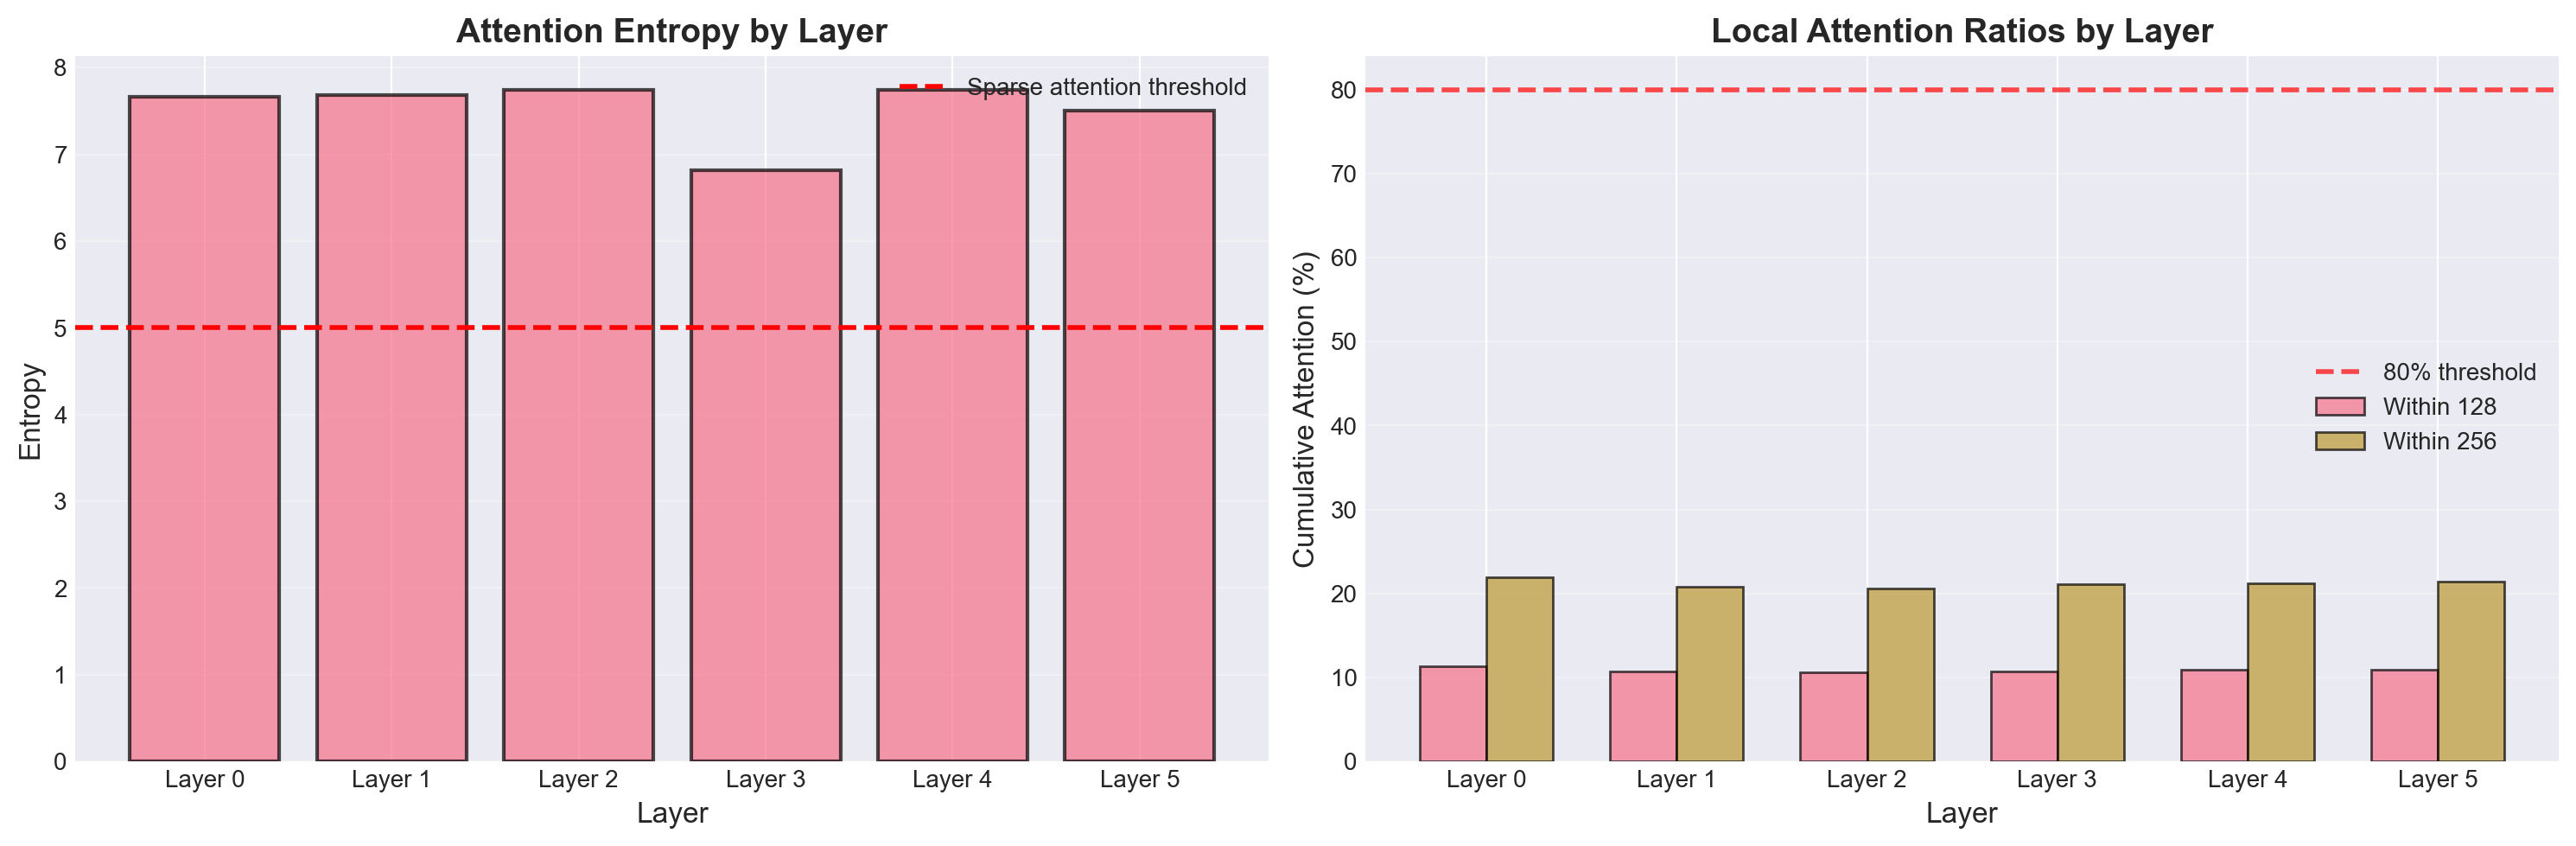

In [ ]:
# Extract mean values for plotting
layer_labels = [f"Layer {i}" for i in range(len(layer_names))]
entropies = [aggregate_metrics[layer]['entropy']['mean'] for layer in layer_names]
local_128 = [aggregate_metrics[layer]['local_ratio_128']['mean'] * 100 for layer in layer_names]
local_256 = [aggregate_metrics[layer]['local_ratio_256']['mean'] * 100 for layer in layer_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Entropy by layer
ax1.bar(layer_labels, entropies, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(5.0, color='r', linestyle='--', linewidth=2, label='Sparse attention threshold')
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Entropy', fontsize=12)
ax1.set_title('Attention Entropy by Layer', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Local attention ratios
x = np.arange(len(layer_labels))
width = 0.35
ax2.bar(x - width/2, local_128, width, label='Within 128', alpha=0.7, edgecolor='black')
ax2.bar(x + width/2, local_256, width, label='Within 256', alpha=0.7, edgecolor='black')
ax2.axhline(80, color='r', linestyle='--', linewidth=2, alpha=0.7, label='80% threshold')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Cumulative Attention (%)', fontsize=12)
ax2.set_title('Local Attention Ratios by Layer', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(layer_labels)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'metrics_by_layer.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Analyze by Sleep Stage

This analysis uses the 4-class sleep staging scheme:
- **Wake**
- **Light sleep** (N1 + N2 combined)
- **Deep sleep** (N3 - slow-wave sleep)
- **REM sleep** (rapid eye movement)

In [ ]:
print(f"Analyzing attention patterns by sleep stage ({NUM_SAMPLES_SLEEP_STAGE} samples)...")

# Determine number of classes from model
n_classes = model.classifier[-1].out_features
print(f"Model has {n_classes} output classes\n")

# 4-class scheme: Wake, Light (N1+N2), Deep (N3), REM
stage_names = ['Wake', 'Light', 'Deep', 'REM']
print("Using 4-class labels:")
print("  0: Wake")
print("  1: Light sleep (N1 + N2)")
print("  2: Deep sleep (N3)")
print("  3: REM sleep")

# Collect attention for ALL layers
all_layer_stage_data = {}

sample_count = 0
for ppg, ecg, labels in test_loader:
    if sample_count >= NUM_SAMPLES_SLEEP_STAGE:
        break
    
    attention_weights, _ = analyzer.analyze_batch(ppg, ecg, labels)
    
    # Process EACH layer
    for layer_name, layer_attn in attention_weights.items():
        # Initialize data structure for this layer if needed
        if layer_name not in all_layer_stage_data:
            all_layer_stage_data[layer_name] = {
                'stage_attention_sum': {stage: None for stage in range(n_classes)},
                'stage_attention_count': {stage: 0 for stage in range(n_classes)},
                'stage_entropies': {stage: [] for stage in range(n_classes)}
            }
        
        # Get average attention across heads for this layer
        attn = layer_attn.mean(dim=1).squeeze(0).numpy()
        
        # Attention matrix is 2400×2400, but labels are for 1200 windows
        # Each window corresponds to 2 attention positions
        for window_idx, stage in enumerate(labels.squeeze()):
            stage = int(stage.item())
            if stage >= 0 and stage < n_classes:  # Valid stage
                layer_data = all_layer_stage_data[layer_name]
                
                # Accumulate average instead of storing all
                if layer_data['stage_attention_sum'][stage] is None:
                    layer_data['stage_attention_sum'][stage] = attn.copy()
                else:
                    layer_data['stage_attention_sum'][stage] += attn
                layer_data['stage_attention_count'][stage] += 1
                
                # Map window index to attention matrix position
                # Each of 1200 windows maps to 2 positions in the 2400×2400 matrix
                attention_idx = window_idx * 2
                if attention_idx < attn.shape[0]:
                    window_attn = attn[attention_idx]
                    window_attn_norm = window_attn / (window_attn.sum() + 1e-9)
                    ent = entropy(window_attn_norm + 1e-9)
                    layer_data['stage_entropies'][stage].append(ent)
    
    sample_count += 1
    if sample_count % 10 == 0:
        print(f"  Processed {sample_count}/{NUM_SAMPLES_SLEEP_STAGE} samples")

# Compute averages for each layer
for layer_name, layer_data in all_layer_stage_data.items():
    layer_data['stage_attention_avg'] = {}
    for stage in range(n_classes):
        if layer_data['stage_attention_sum'][stage] is not None and layer_data['stage_attention_count'][stage] > 0:
            layer_data['stage_attention_avg'][stage] = (
                layer_data['stage_attention_sum'][stage] / layer_data['stage_attention_count'][stage]
            )

print(f"\n✓ Sleep stage analysis complete for {len(all_layer_stage_data)} layers")

# Print stage counts (same across all layers)
first_layer_data = list(all_layer_stage_data.values())[0]
print(f"\nStage counts:")
for stage in range(n_classes):
    print(f"  {stage_names[stage]:8s}: {first_layer_data['stage_attention_count'][stage]:5d} windows")

In [ ]:
# Create plots for EACH layer
print(f"Creating sleep stage attention plots for {len(all_layer_stage_data)} layers...")

# Determine grid size based on number of classes
if n_classes <= 4:
    nrows, ncols = 2, 2
elif n_classes <= 6:
    nrows, ncols = 2, 3
else:
    nrows, ncols = 3, 3

# Create a separate figure for each layer
for layer_idx, (layer_name, layer_data) in enumerate(all_layer_stage_data.items()):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
    axes = axes.flatten() if n_classes > 1 else [axes]
    
    # Extract short layer name for title
    short_layer_name = layer_name.split('.')[-1]  # e.g., "ppg_cross_attn"
    layer_num = layer_name.split('.')[1]  # e.g., "0", "1", "2"
    
    # Plot attention for each stage
    for stage in range(n_classes):
        if stage in layer_data['stage_attention_avg']:
            avg_attn = layer_data['stage_attention_avg'][stage]
            
            im = axes[stage].imshow(avg_attn, aspect='auto', cmap='viridis', 
                                   interpolation='nearest', vmin=0)
            axes[stage].set_title(
                f'{stage_names[stage]} (n={layer_data["stage_attention_count"][stage]} windows)',
                fontsize=14, fontweight='bold'
            )
            axes[stage].set_xlabel('Key Position', fontsize=11)
            axes[stage].set_ylabel('Query Position', fontsize=11)
            plt.colorbar(im, ax=axes[stage])
        else:
            axes[stage].axis('off')
            axes[stage].text(0.5, 0.5, f'{stage_names[stage]}\nNo Data', 
                            ha='center', va='center', fontsize=14)
    
    # Summary statistics in the last subplot
    summary_idx = n_classes
    if summary_idx < len(axes):
        axes[summary_idx].axis('off')
        summary_text = f"Layer: {short_layer_name}\n\n"
        summary_text += "Average Entropy by Stage:\n\n"
        for stage in range(n_classes):
            if layer_data['stage_entropies'][stage]:
                avg_ent = np.mean(layer_data['stage_entropies'][stage])
                summary_text += f"{stage_names[stage]:8s}: {avg_ent:.3f}\n"
            else:
                summary_text += f"{stage_names[stage]:8s}: N/A\n"
        
        axes[summary_idx].text(0.1, 0.5, summary_text, fontsize=16, 
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide any extra subplots
    for idx in range(n_classes + 1, len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    fig.suptitle(f'Attention by Sleep Stage - {layer_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    # Save with layer-specific filename
    save_name = f'attention_by_sleep_stage_layer{layer_num}_{short_layer_name}.png'
    plt.savefig(output_dir / save_name, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved {save_name}")
    plt.show()

print(f"\n✓ Created {len(all_layer_stage_data)} sleep stage attention plots")

## 14. Identify Optimization Opportunities

In [ ]:
# Use mean metrics for opportunity analysis
mean_metrics = {
    layer: {k: v['mean'] if isinstance(v, dict) else v 
            for k, v in metrics.items()}
    for layer, metrics in aggregate_metrics.items()
}

opportunities = {
    'can_use_local_attention': [],
    'highly_focused_layers': [],
    'recommended_band_width': {}
}

for layer_name, layer_metrics in mean_metrics.items():
    # Check for local attention opportunities
    if layer_metrics['local_ratio_128'] > 0.8:
        opportunities['can_use_local_attention'].append({
            'layer': layer_name,
            'local_ratio': layer_metrics['local_ratio_128'],
            'window': 128
        })
    elif layer_metrics['local_ratio_256'] > 0.85:
        opportunities['can_use_local_attention'].append({
            'layer': layer_name,
            'local_ratio': layer_metrics['local_ratio_256'],
            'window': 256
        })
    
    # Check for highly focused attention
    if layer_metrics['entropy'] < 5.0:
        opportunities['highly_focused_layers'].append({
            'layer': layer_name,
            'entropy': layer_metrics['entropy']
        })
    
    # Recommend band width
    if layer_metrics['local_ratio_64'] > 0.75:
        opportunities['recommended_band_width'][layer_name] = 64
    elif layer_metrics['local_ratio_128'] > 0.75:
        opportunities['recommended_band_width'][layer_name] = 128
    elif layer_metrics['local_ratio_256'] > 0.75:
        opportunities['recommended_band_width'][layer_name] = 256
    else:
        opportunities['recommended_band_width'][layer_name] = 'full'

print("✓ Optimization opportunities identified")

✓ Optimization opportunities identified


## 15. Summary and Recommendations

In [ ]:
print("\n" + "="*80)
print("SPARSE ATTENTION OPTIMIZATION OPPORTUNITIES")
print("="*80)

print("\n📊 Layers that can use LOCAL ATTENTION (save ~50% computation):")
if opportunities['can_use_local_attention']:
    for opp in opportunities['can_use_local_attention']:
        print(f"  • {opp['layer']}")
        print(f"    Window size: {opp['window']}")
        print(f"    Local ratio: {opp['local_ratio']*100:.1f}%")
else:
    print("  None identified - full attention may be necessary")

print("\n📊 Layers with HIGHLY FOCUSED attention (can use top-k sparsity):")
if opportunities['highly_focused_layers']:
    for opp in opportunities['highly_focused_layers']:
        print(f"  • {opp['layer']} (entropy: {opp['entropy']:.2f})")
        print(f"    Recommendation: Use top-k sparse attention with k=128 or k=256")
else:
    print("  None identified")

print("\n📊 RECOMMENDED BAND WIDTHS per layer:")
for layer, width in opportunities['recommended_band_width'].items():
    print(f"  • {layer}: {width}")

# Calculate potential savings
local_attention_layers = len(opportunities['can_use_local_attention'])
total_layers = len(layer_names)

print("\n💡 OPTIMIZATION RECOMMENDATIONS:")
if local_attention_layers > 0:
    potential_savings = (local_attention_layers / total_layers) * 50
    print(f"  1. Implement local attention on {local_attention_layers}/{total_layers} layers")
    print(f"     → Potential computation savings: ~{potential_savings:.0f}%")

if opportunities['highly_focused_layers']:
    print(f"  2. Implement top-k sparse attention on {len(opportunities['highly_focused_layers'])} layers")
    print(f"     → Use k = 128 or 256 to maintain performance")

if cumulative_attn[3] > 0.85:  # Band width 128
    print(f"  3. {cumulative_attn[3]*100:.1f}% of attention is within 128 timesteps")
    print(f"     → Strong candidate for local window attention")

print("\n" + "="*80)


SPARSE ATTENTION OPTIMIZATION OPPORTUNITIES

📊 Layers that can use LOCAL ATTENTION (save ~50% computation):
  None identified - full attention may be necessary

📊 Layers with HIGHLY FOCUSED attention (can use top-k sparsity):
  None identified

📊 RECOMMENDED BAND WIDTHS per layer:
  • fusion_blocks.0.ppg_cross_attn: full
  • fusion_blocks.0.ecg_cross_attn: full
  • fusion_blocks.1.ppg_cross_attn: full
  • fusion_blocks.1.ecg_cross_attn: full
  • fusion_blocks.2.ppg_cross_attn: full
  • fusion_blocks.2.ecg_cross_attn: full

💡 OPTIMIZATION RECOMMENDATIONS:



## 16. Save Results

In [ ]:
# Prepare results dictionary
results = {
    'timestamp': TIMESTAMP,
    'checkpoint': str(checkpoint_path),
    'attention_type': ATTENTION_TYPE,
    'num_samples_analyzed': len(all_metrics),
    'aggregate_metrics': aggregate_metrics,
    'sparse_attention_opportunities': opportunities,
    'band_analysis': {
        'band_edges': [int(b) for b in band_edges],
        'band_labels': band_labels,
        'incremental_strengths': [float(s) for s in incremental_strengths],
        'incremental_mass': [float(m) for m in incremental_mass],
        'cumulative_attention': [float(c) for c in cumulative_attn]
    }
}

# Save to JSON
results_path = output_dir / 'analysis_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to: {results_path}")
print(f"✓ Figures saved to: {output_dir}")
print(f"\n📁 Output directory: {output_dir.absolute()}")


✓ Results saved to: outputs\attention_analysis_20251118_003131\analysis_results.json
✓ Figures saved to: outputs\attention_analysis_20251118_003131

📁 Output directory: c:\Users\james\Documents\repos\ppg-sleep-stage-classifier\src\sleep-staging-models\outputs\attention_analysis_20251118_003131


## 17. Summary Statistics Table

In [ ]:
import pandas as pd

# Create summary DataFrame
summary_data = []
for layer_name in layer_names:
    metrics = mean_metrics[layer_name]
    summary_data.append({
        'Layer': layer_name.split('.')[-2],  # Extract layer number
        'Entropy': f"{metrics['entropy']:.2f}",
        'Mean Attn': f"{metrics['mean']:.6f}",
        'Diagonal': f"{metrics['diagonal_ratio']:.2f}",
        'Local 64': f"{metrics['local_ratio_64']*100:.1f}%",
        'Local 128': f"{metrics['local_ratio_128']*100:.1f}%",
        'Local 256': f"{metrics['local_ratio_256']*100:.1f}%",
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(df_summary.to_string(index=False))

# Save to CSV
df_summary.to_csv(output_dir / 'summary_metrics.csv', index=False)
print(f"\n✓ Table saved to: {output_dir / 'summary_metrics.csv'}")


SUMMARY TABLE
Layer Entropy Mean Attn Diagonal Local 64 Local 128 Local 256
    0    7.67  0.000417     1.06     5.7%     11.3%     21.9%
    0    7.69  0.000417     1.03     5.4%     10.7%     20.8%
    1    7.74  0.000417     1.01     5.4%     10.6%     20.6%
    1    6.82  0.000417     1.01     5.4%     10.7%     21.1%
    2    7.75  0.000417     1.04     5.6%     10.9%     21.2%
    2    7.50  0.000417     1.03     5.5%     10.9%     21.4%

✓ Table saved to: outputs\attention_analysis_20251118_003131\summary_metrics.csv


---

## ✅ Analysis Complete!

All results have been saved to the output directory. Key files:
- `attention_heatmap_layer0.png` - Detailed visualization of first layer
- `local_attention_bands.png` - Local attention band analysis
- `metrics_by_layer.png` - Metrics comparison across layers
- `attention_by_sleep_stage.png` - Attention patterns per sleep stage
- `analysis_results.json` - Complete numerical results
- `summary_metrics.csv` - Summary table

Use the recommendations above to optimize your model with sparse attention mechanisms!